In [116]:
import pandas as pd
import numpy as np

In [117]:
df00 = pd.read_csv("/Users/nilswaffenschmidt/Downloads/T00.featureCounts.tsv", sep="\t", skiprows=1)[["Geneid", "Length", "T00.bam"]]
df01 = pd.read_csv("/Users/nilswaffenschmidt/Downloads/T01.featureCounts.tsv", sep="\t", skiprows=1)[["Geneid", "T01.bam"]]
df04 = pd.read_csv("/Users/nilswaffenschmidt/Downloads/T04.featureCounts.tsv", sep="\t", skiprows=1)[["Geneid", "T04.bam"]]
df07 = pd.read_csv("/Users/nilswaffenschmidt/Downloads/T07.featureCounts.tsv", sep="\t", skiprows=1)[["Geneid", "T07.bam"]]
df20 = pd.read_csv("/Users/nilswaffenschmidt/Downloads/T20.featureCounts.tsv", sep="\t", skiprows=1)[["Geneid", "T20.bam"]]

In [118]:
df = df00.merge(df01, on="Geneid") \
         .merge(df04, on="Geneid") \
         .merge(df07, on="Geneid") \
         .merge(df20, on="Geneid")

df.columns = ["Geneid", "Length", 0, 1, 4, 7, 20]
df

,Geneid,Length,0,1,4,7,20
0,gene-T4p001,2178,10,12,9410,37892,7586
1,gene-T4p002,204,1,0,1467,4199,724
2,gene-T4p003,533,6,3,3550,14110,4160
3,gene-T4p004,381,4,9,1537,4465,1272
4,gene-T4p005,114,1,12,775,1970,421
...,...,...,...,...,...,...,...
283,gene-T4p274,99,1,217,2064,1539,99
284,gene-T4p275,87,0,65,67,202,79
285,gene-T4p276,558,0,1,492,3849,2663
286,gene-T4p277,195,3,2,247,2473,1504


In [119]:
library_sizes = {
    0 : 2.5e6,
    1 : 2.5e6,
    4 : 2.5e6,
    7 : 2.5e6,
    20 : 2.5e6
}

In [120]:
def tpm_with_libsizes(df, length_col="Length", lib_sizes=None):
    df_tpm = df.copy()
    sample_cols = [c for c in df.columns if c not in ["Geneid", length_col]]

    for sample in sample_cols:
        if sample not in lib_sizes:
            raise ValueError(f"Missing library size for sample '{sample}'")

        # Step 1: compute RPK (reads per kilobase)
        rpk = df[sample] / (df[length_col] / 1000)

        # Step 2: use provided total library size to compute scaling factor
        # scaling_factor = total_reads / 1e6
        scaling_factor = lib_sizes[sample] / 1e6

        # Step 3: compute TPM
        df_tpm[sample] = rpk / scaling_factor

    return df_tpm

df_tpm = tpm_with_libsizes(df, "Length", library_sizes)
df_tpm = df_tpm.dropna()

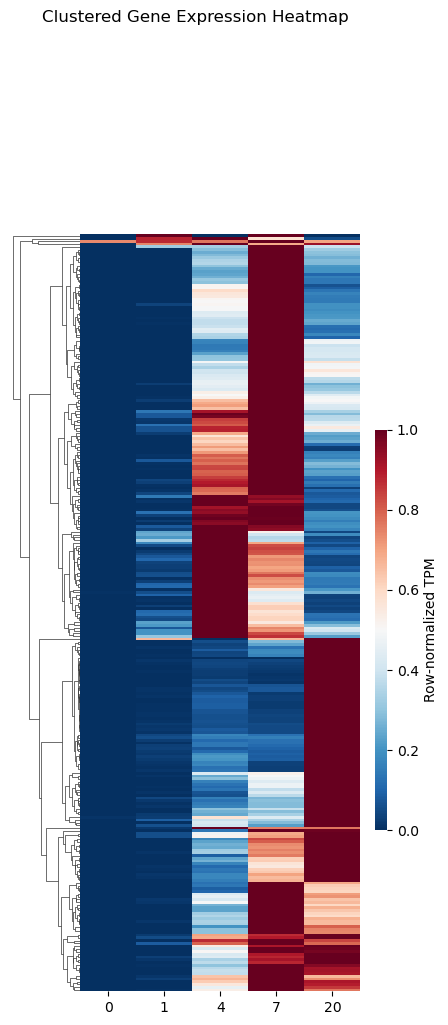

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Geneid as index
heatmap_df = df_tpm.set_index("Geneid").drop("Length", axis=1)

# Optional normalization (so clustering is driven by relative patterns, not absolute counts)
df_tpm_norm = heatmap_df.div(heatmap_df.max(axis=1), axis=0)
df_tpm_norm = df_tpm_norm.dropna()

# Create clustermap
g = sns.clustermap(
    df_tpm_norm,
    cmap="RdBu_r",
    metric="euclidean",
    method="average",
    figsize=(4, 10),
    row_cluster=True,
    col_cluster=False,
    yticklabels=False,       # hide row tick labels<
    cbar_kws={'label': 'Row-normalized TPM'},
    cbar_pos=(0.95, 0.2, 0.03, 0.4)
)

# Remove axis labels
g.ax_heatmap.set_ylabel('')

plt.suptitle("Clustered Gene Expression Heatmap", y=1.02)
g.savefig("/Users/nilswaffenschmidt/waffenschmidt/project/Figures/heatmap.pdf")        # PDF file
plt.show()

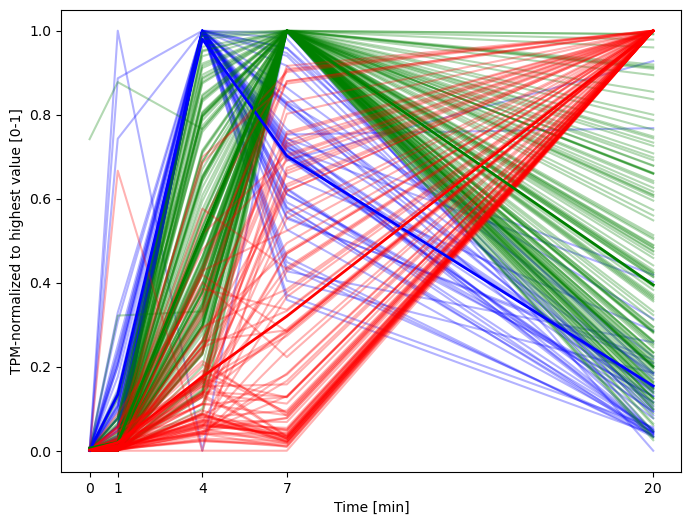

In [ ]:
timepoints = [0, 1, 4, 7, 20]

# ---------- Classify genes by max expression ---------- #
# Find which column has max expression per gene
df_tpm_norm['max_tp'] = df_tpm_norm[timepoints].idxmax(axis=1)
def classify(tp):
    if tp in [0, 1, 4]:
        return "early"
    elif tp == 7:
        return "middle"
    elif tp == 20:
        return "late"
    else:
        return "unknown"
df_tpm_norm['class'] = df_tpm_norm['max_tp'].apply(classify)


# ---------- Normalize genes individually 0-1 for profile plot ---------- #
df_profile = df_tpm_norm.copy()
df_profile[timepoints] = df_profile[timepoints].div(df_profile[timepoints].max(axis=1), axis=0)


# ---------- Profile plot ---------- #
plt.figure(figsize=(8, 6))
colors = {"early": "blue", "middle": "green", "late": "red"}

# Plot all genes
for cls, color in colors.items():
    subset = df_profile[df_profile['class'] == cls]
    for _, row in subset[timepoints].iterrows():  # iterate over genes
        plt.plot(timepoints, row.values, color=color, alpha=0.3)

# Overlay class mean
for cls, color in colors.items():
    subset = df_profile[df_profile['class'] == cls]
    mean_profile = subset[timepoints].mean(axis=0)
    plt.plot(timepoints, mean_profile.values, label=f"{cls} mean", color=color, linewidth=2)

plt.xlabel("Time [min]")
plt.ylabel("TPM-normalized to highest value [0-1]")
plt.xticks(timepoints)
plt.savefig("/Users/nilswaffenschmidt/waffenschmidt/project/Figures/profile_plot.pdf")
plt.show()

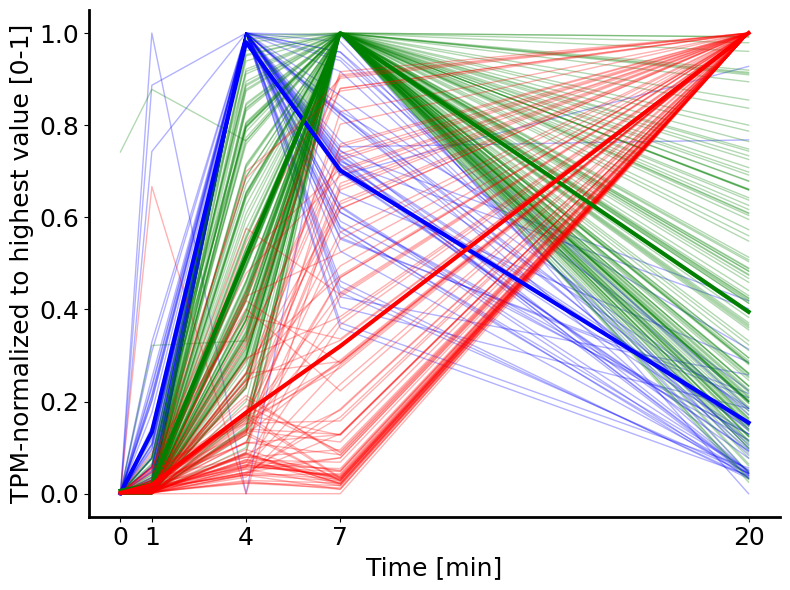

In [173]:
plt.figure(figsize=(8, 6))
colors = {"early": "blue", "middle": "green", "late": "red"}

# Plot all genes
for cls, color in colors.items():
    subset = df_profile[df_profile['class'] == cls]
    for _, row in subset[timepoints].iterrows():  # iterate over genes
        plt.plot(timepoints, row.values, color=color, alpha=0.3, linewidth=1)  # slightly thicker individual lines

# Overlay class mean
for cls, color in colors.items():
    subset = df_profile[df_profile['class'] == cls]
    mean_profile = subset[timepoints].mean(axis=0)
    plt.plot(mean_profile.index, mean_profile.values, label=f"{cls} mean", color=color, linewidth=3)  # thicker mean lines

# Style adjustments (match bar plot style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

ax.tick_params(left=True, bottom=True, labelsize=18)  # increase tick label size

# Set thickness
ax.spines['left'].set_linewidth(2)    # y-axis thicker
ax.spines['bottom'].set_linewidth(2)  # x-axis thicker

plt.xlabel("Time [min]", fontsize=18)
plt.ylabel("TPM-normalized to highest value [0-1]", fontsize=18)
plt.xticks(timepoints, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("/Users/nilswaffenschmidt/waffenschmidt/project/Figures/profile_plot.pdf")
plt.show()


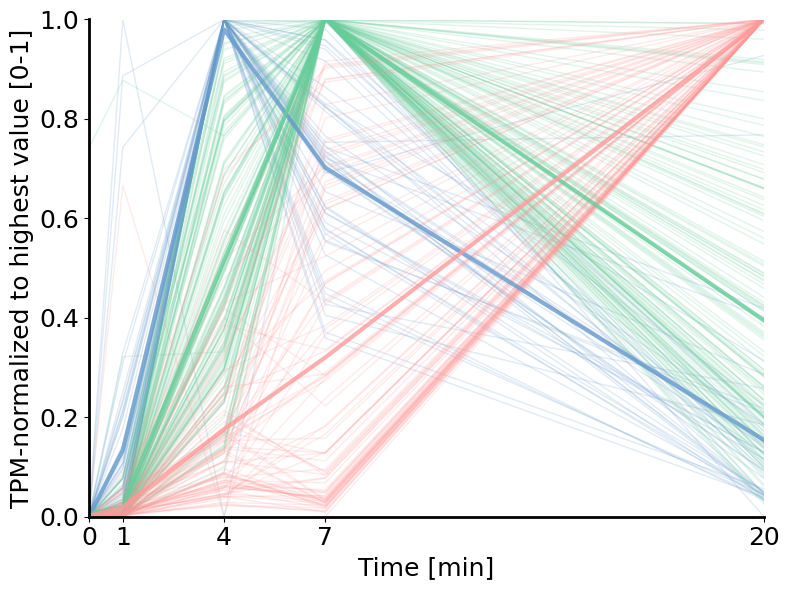

In [178]:
plt.figure(figsize=(8, 6))
# Lighter colors for classes
colors = {"early": "#6699CC", "middle": "#66CC99", "late": "#FF9999"}  # soft blue, green, red

# Plot all genes with light transparency
for cls, color in colors.items():
    subset = df_profile[df_profile['class'] == cls]
    for _, row in subset[timepoints].iterrows():
        plt.plot(timepoints, row.values, color=color, alpha=0.2, linewidth=1)  # lighter individual lines

# Overlay class mean with slightly stronger color
for cls, color in colors.items():
    subset = df_profile[df_profile['class'] == cls]
    mean_profile = subset[timepoints].mean(axis=0)
    plt.plot(mean_profile.index, mean_profile.values, label=f"{cls} mean", color=color, linewidth=3, alpha=0.8)

# Style adjustments (match bar plot style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

ax.tick_params(left=True, bottom=True, labelsize=18)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Set axis limits starting at 0
plt.xlim(0, max(timepoints))        # x-axis from 0 to max timepoint
plt.ylim(0, 1)                      # y-axis from 0 to 1, since normalized 0-1

plt.xlabel("Time [min]", fontsize=18)
plt.ylabel("TPM-normalized to highest value [0-1]", fontsize=18)
plt.xticks(timepoints, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("/Users/nilswaffenschmidt/waffenschmidt/project/Figures/profile_plot.pdf")
plt.show()


In [136]:
df_profile

,0,1,4,7,20,max_tp,class
Geneid,,,,,,,
gene-T4p001,0.000264,0.000317,0.248337,1.00000,0.200201,7,middle
gene-T4p002,0.000238,0.000000,0.349369,1.00000,0.172422,7,middle
gene-T4p003,0.000425,0.000213,0.251595,1.00000,0.294826,7,middle
gene-T4p004,0.000896,0.002016,0.344233,1.00000,0.284882,7,middle
gene-T4p005,0.000508,0.006091,0.393401,1.00000,0.213706,7,middle
...,...,...,...,...,...,...,...
gene-T4p274,0.000484,0.105136,1.000000,0.74564,0.047965,4,early
gene-T4p275,0.000000,0.321782,0.331683,1.00000,0.391089,7,middle
gene-T4p276,0.000000,0.000260,0.127825,1.00000,0.691868,7,middle


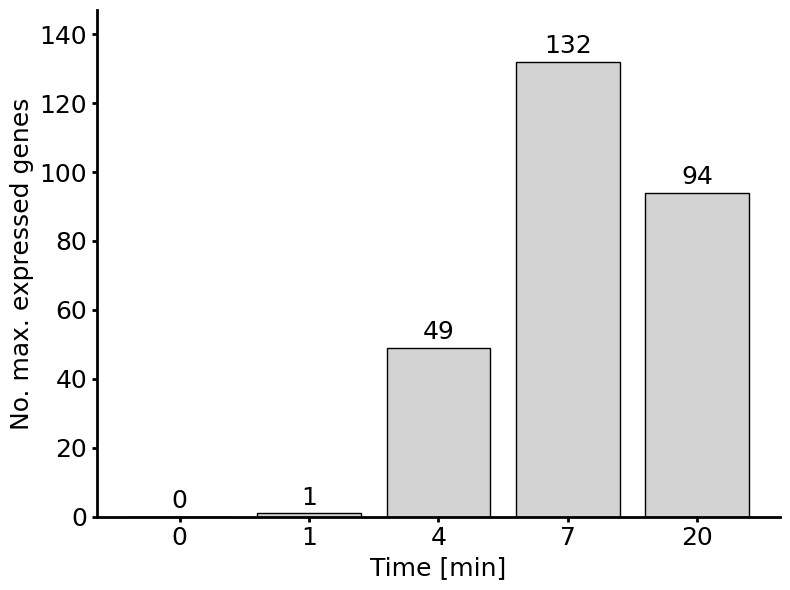

In [175]:
import matplotlib.pyplot as plt

# Count number of genes with max expression at each timepoint
counts = df_tpm_norm['max_tp'].value_counts().reindex(timepoints).fillna(0)

plt.figure(figsize=(8, 6))

# Grey bars
bars = plt.bar(counts.index.astype(str), counts.values, color="lightgrey", edgecolor="black")

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,  # slightly above bar
             f'{int(height)}', ha='center', va='bottom', fontsize=18)

# Style axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Make axes thicker
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Tick parameters
ax.tick_params(left=True, bottom=True, width=2, labelsize=18)

# Labels
plt.xlabel("Time [min]", fontsize=18)
plt.ylabel("No. max. expressed genes", fontsize=18)
plt.xticks(counts.index.astype(str), fontsize=18)
plt.ylim(0, counts.values.max() + 15)  # leave space for text above bars

plt.tight_layout()
plt.savefig("/Users/nilswaffenschmidt/waffenschmidt/project/Figures/bar_plot.pdf")
plt.show()



In [ ]:
df

,Geneid,Length,0,1,4,7,20,max_tp,class
0,gene-T4p001,2178,10,12,9410,37892,7586,7,unknown
1,gene-T4p002,204,1,0,1467,4199,724,7,unknown
2,gene-T4p003,533,6,3,3550,14110,4160,7,unknown
3,gene-T4p004,381,4,9,1537,4465,1272,7,unknown
4,gene-T4p005,114,1,12,775,1970,421,7,unknown
...,...,...,...,...,...,...,...,...,...
283,gene-T4p274,99,1,217,2064,1539,99,4,unknown
284,gene-T4p275,87,0,65,67,202,79,7,unknown
285,gene-T4p276,558,0,1,492,3849,2663,7,unknown
286,gene-T4p277,195,3,2,247,2473,1504,7,unknown
